In [ ]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import datetime

def obtener_tiempo(dfr):
    #Esta funcion permite obtener una columna Datetime a partir del agno, dia, hora y minuto de los datos iniciales
    dfr['Day'] = pd.to_datetime(dfr['Day'], format='%j').dt.strftime('%m-%d')
    dfr['Hour'] = dfr['Hour'].astype(str).str.zfill(2)
    dfr['Datetime'] = pd.to_datetime(dfr[['Year','Day', 'Hour', 'Minute']]
                   .astype(str).apply(' '.join, 1), format='%Y %m-%d %H %M') 
    return dfr

def sustituir(dfr):
    #Sustitucion de los valores 9999... por NaN (sabemos que la fila 2 son todo valores nulos para cada variable)
    valores_null = dfr.iloc[2, 4:]
    for i in range(len(valores_null)):
        dfr.iloc[:,i+4] = dfr.iloc[:,i+4].replace(valores_null[i], np.nan)
    return dfr

def imputar_por_interpolacion(dfr):
    #Sustituye los valores NaN por valores aproximados mediante el metodo de interpolacion
    dfr = dfr.interpolate(method='linear', limit_direction='forward')
    return dfr

def imputar_por_KNND(dfr):
    #Este metodo es para imputar las filas que no se hayan podido imputar con interpolacion (primera fila)
    imputer = KNNImputer(n_neighbors=3, weights = 'distance')
    dfr[:] = imputer.fit_transform(dfr)
    return dfr

def normalizar_datos_standardScaler(dfr):
    #Dado un DataFrame, devuelve el DataFrame con valores normalizados
    x = dfr.values #returns a numpy array
    standard_scaler = preprocessing.StandardScaler()
    dfr[:] = standard_scaler.fit_transform(x)
    #dfr = pd.DataFrame(x_scaled)
    return dfr

def normalizar_datos_MinMaxScaler(dfr):
    #Dado un DataFrame, devuelve el DataFrame con valores normalizados
    x = dfr.values #returns a numpy array
    minmax_scaler = preprocessing.MinMaxScaler()
    dfr[:] = minmax_scaler.fit_transform(x)
    #dfr = pd.DataFrame(x_scaled)
    return dfr

def desnormalizar_datos(dfr):
    #Dado un DataFrame, devuelve el DataFrame con valores desnormalizados
    x = dfr.values
    min_max_scaler = preprocessing.MinMaxScaler()
    dfr[:] = min_max_scaler.inverse_transform(x)
    return dfr

def preprocesar(df):
  df = sustituir(df)
  df = imputar_por_interpolacion(df)
  df = imputar_por_KNND(df.iloc[:3, :])
  df = obtener_tiempo(df)
  df = df.drop(['Year', 'Day', 'Hour', 'Minute'], axis = 1)
  df = df.set_index('Datetime')


#**1-Montamos Drive para poder acceder a los datos y los leemos**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_i = pd.read_csv('/content/drive/MyDrive/TFG_codigo/Prediccion_general/datos.csv', header=0)

#**2-Preprocesamos los datos y los normalizamos**

In [ ]:
#2-Preprocesamos los datos
df = sustituir(df_i)
#df = imputar_por_interpolacion(df)
#imputar_por_KNND(df.iloc[:3, :])
df.fillna(method='ffill', inplace=True)
df = obtener_tiempo(df)
df = df.drop(['Year', 'Day', 'Hour', 'Minute'], axis = 1)
df = df.set_index('Datetime')
df['tormenta'] = 500
df = normalizar_datos_standardScaler(df) #Los datos se deben normalizar despues de la division de datos
df

,IMF(nT),Bx GSM(nT),By GSM(nT),Bz GSM(nT),Flow Speed(km/s),Proton Density(n/cc),Proton Temperature(K),tormenta
Datetime,,,,,,,,
1995-01-01 00:00:00,-1.425288,0.032928,0.291836,-0.189460,NaN,NaN,NaN,0.0
1995-01-01 00:05:00,-1.461611,0.021724,0.279169,-0.138113,-1.147689,2.344976,-0.812702,0.0
1995-01-01 00:10:00,-1.461611,0.021724,0.279169,-0.138113,-1.147689,2.344976,-0.812702,0.0
1995-01-01 00:15:00,-1.461611,0.021724,0.279169,-0.138113,-1.147689,2.344976,-0.812702,0.0
1995-01-01 00:20:00,-1.461611,0.021724,0.279169,-0.138113,-1.147689,2.344976,-0.812702,0.0
...,...,...,...,...,...,...,...,...
2021-02-18 23:35:00,-0.929967,0.593110,0.003030,-0.548885,-0.622059,-0.343903,-0.356813,0.0
2021-02-18 23:40:00,-0.913457,0.615517,0.013163,-0.554926,-0.614080,-0.396550,-0.308430,0.0
2021-02-18 23:45:00,-0.920061,0.682739,0.008096,-0.452233,-0.622059,-0.347803,-0.355595,0.0


#3-**Fechas de las tormentas geomagnéticas**

In [ ]:
#Para que coja hasta el 00

TRAINING_STORMS_DATES_START = ['19980214', '19980802', '19980919', '19990216', '19991015', '20000709', '20000806', '20000915', '20001101',
                               '20010314', '20010406', '20011017', '20011031', '20020517', '20031115', '20040720', '20050510', '20060409', '20061209', '20120301']
TRAINING_STORMS_DATES_END = ['199802230000', '199808080000', '199809300000', '199902250000', '199910260000', '200007200000', '200008170000', '200009260000', '200011160000',
                             '200103250000', '200104170000', '200110230000', '200111110000', '200205280000', '200311260000', '200407310000', '200505210000', '200604200000', '200612200000', '201203120000']

VALIDATION_STORMS_DATES_START = [
    '19980428', '19990919', '20031025', '20150618', '20170901']
VALIDATION_STORMS_DATES_END = [
    '199805090000', '199909270000', '200311040000', '201506290000', '201709120000']

TESTING_STORMS_DATES_START = ['19980622', '19981102', '19990109', '19990413', '20000116', '20000402', '20000519',
                              '20010326', '20030526', '20030708', '20040118', '20041104', '20120910', '20130528', '20130626', '20150311', '20180822']
TESTING_STORMS_DATES_END = ['199807010000', '199811130000', '199901190000', '199904200000', '200001270000', '200004130000', '200005290000', '200104050000',
                            '200306070000', '200307190000', '200401280000', '200411150000', '201210060000', '201306050000', '201307050000', '201503220000', '201809040000']

In [ ]:
#ORIGINAL
TRAINING_STORMS_DATES_START = ['19980214', '19980802', '19980919', '19990216', '19991015', '20000709', '20000806', '20000915', '20001101',
                               '20010314', '20010406', '20011017', '20011031', '20020517', '20031115', '20040720', '20050510', '20060409', '20061209', '20120301']
TRAINING_STORMS_DATES_END = ['199802222359', '199808082359', '199809292359', '199902242359', '199910252359', '200007192359', '200008162359', '200009252359', '200011152359',
                             '200103242359', '200104162359', '200110222359', '200111102359', '200205272359', '200311252359', '200407302359', '200505202359', '200604192359', '200612192359', '201203112359']

VALIDATION_STORMS_DATES_START = [
    '19980428', '19990919', '20031025', '20150618', '20170901']
VALIDATION_STORMS_DATES_END = [
    '199805082359', '199909262359', '200311032359', '201506282359', '201709112359']

TESTING_STORMS_DATES_START = ['19980622', '19981102', '19990109', '19990413', '20000116', '20000402', '20000519',
                              '20010326', '20030526', '20030708', '20040118', '20041104', '20120910', '20130528', '20130626', '20150311', '20180822']
TESTING_STORMS_DATES_END = ['199806302359', '199811122359', '199901182359', '199904192359', '200001262359', '200004122359', '200005282359', '200104042359',
                            '200306062359', '200307182359', '200401272359', '200411142359', '201210052359', '201306042359', '201307042359', '201503212359', '201809032359']

**Definición de funciones para hacer un split de las tormentas**

In [ ]:
def split_tormentas(df, train_start_dates = TRAINING_STORMS_DATES_START, train_end_dates = TRAINING_STORMS_DATES_END,
                    val_start_dates = VALIDATION_STORMS_DATES_START, val_end_dates = VALIDATION_STORMS_DATES_END, test_start_dates = TESTING_STORMS_DATES_START, test_end_dates = TESTING_STORMS_DATES_END):
  
  indice_tormenta = 0
  
  tormentas_train = []
  tormentas_val   = []
  tormentas_test  = []

  for start, end in zip(train_start_dates, train_end_dates):
    tormenta = df.loc[start:end].copy()
    tormenta['tormenta'] = indice_tormenta
    tormentas_train.append(tormenta)
    indice_tormenta = indice_tormenta + 1

  for start, end in zip(val_start_dates, val_end_dates):
    tormenta = df.loc[start:end].copy()
    tormenta['tormenta'] = indice_tormenta
    tormentas_val.append(tormenta)
    indice_tormenta = indice_tormenta + 1

  for start, end in zip(test_start_dates, test_end_dates):
    tormenta = df.loc[start:end].copy()
    tormenta['tormenta'] = indice_tormenta
    tormentas_test.append(tormenta)
    indice_tormenta = indice_tormenta + 1

  df_train = tormentas_train[0]
  df_val   = tormentas_val[0]
  df_test  = tormentas_test[0]

  for tormenta in range(len(tormentas_train)):
    if(tormenta != 0):
      df_train = pd.concat((df_train, tormentas_train[tormenta]))

  for tormenta in range(len(tormentas_val)):
    if(tormenta != 0):
      df_val = pd.concat((df_val, tormentas_val[tormenta]))

  for tormenta in range(len(tormentas_test)):
    if(tormenta != 0):
      df_test = pd.concat((df_test, tormentas_test[tormenta]))
  

  return df_train, df_val, df_test

In [ ]:
df_train, df_val, df_test = split_tormentas(df)

In [ ]:
df_train.set_index('tormenta', append=True, inplace=True)
df_val.set_index('tormenta', append=True, inplace=True)
df_test.set_index('tormenta', append=True, inplace=True)



In [ ]:
df_train = df_train.reorder_levels(['tormenta', 'Datetime'])
df_val = df_val.reorder_levels(['tormenta', 'Datetime'])
df_test = df_test.reorder_levels(['tormenta', 'Datetime'])
df_train

IMF(nT)  ...  Proton Temperature(K)
tormenta Datetime                       ...                       
0        1998-02-14 00:00:00 -0.200195  ...              -0.553988
         1998-02-14 00:05:00 -0.236519  ...              -0.371863
         1998-02-14 00:10:00 -0.256332  ...              -0.360489
         1998-02-14 00:15:00 -0.279447  ...              -0.442039
         1998-02-14 00:20:00 -0.282749  ...              -0.322992
...                                ...  ...                    ...
19       2012-03-11 23:35:00 -0.550222  ...              -0.835647
         2012-03-11 23:40:00 -0.550222  ...              -0.836932
         2012-03-11 23:45:00 -0.583243  ...              -0.786323
         2012-03-11 23:50:00 -0.609660  ...              -0.800908
         2012-03-11 23:55:00 -0.606358  ...              -0.912823

[60768 rows x 7 columns]

#**4-Creacion de datasets**

**Determinamos los parámetros y funciones para crear los datasets**

In [ ]:
def multivariate_multioutput_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data)[:,:,:,np.newaxis,np.newaxis], np.array(labels)[:,:,:,np.newaxis,np.newaxis]





def timeseries_dataset_from_df1(df, window_entrada = 40, window_salida = 4):
    dataset_x_total = None    
    dataset_y_total = None

    start_ind = 0
    step = 1
    for indice_tormenta, datos_tormenta in df.groupby("tormenta"):
        dataset_x , dataset_y = multivariate_multioutput_data(
            datos_tormenta.values,
            datos_tormenta.values, 
            start_ind,
            None,
            window_entrada,
            window_salida,
            step)

        if dataset_x_total is None:
            dataset_x_total = dataset_x
            dataset_y_total = dataset_y 
        else:
            dataset_x_total = np.concatenate((dataset_x_total, dataset_x))
            dataset_y_total = np.concatenate((dataset_y_total, dataset_y))

    return dataset_x_total, dataset_y_total

In [ ]:
#OBTENEMOS LOS datasets x e y
x_train , y_train = timeseries_dataset_from_df1(df_train)
x_val , y_val     = timeseries_dataset_from_df1(df_val)
x_test , y_test   = timeseries_dataset_from_df1(df_test)


train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.cache().batch(2).repeat()

val_data = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_data = val_data.cache().batch(2).repeat()


test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_data = test_data.cache().batch(2).repeat()

In [ ]:
val_data.take(1)

<TakeDataset shapes: ((None, 40, 7, 1, 1), (None, 4, 7, 1, 1)), types: (tf.float64, tf.float64)>

In [ ]:
print (x_train.shape,
       y_train.shape,
       x_val.shape,
       y_val.shape,
       x_test.shape,
       y_test.shape,
       'Single window of past history : {}'.format(x_train[0].shape),
       'Target temperature to predict : {}'.format(y_train[0].shape),
       sep='\n')

(59888, 40, 7, 1, 1)
(59888, 4, 7, 1, 1)
(14468, 40, 7, 1, 1)
(14468, 4, 7, 1, 1)
(53972, 40, 7, 1, 1)
(53972, 4, 7, 1, 1)
Single window of past history : (40, 7, 1, 1)
Target temperature to predict : (4, 7, 1, 1)


In [ ]:
y_train.shape[1]

4

In [ ]:
#===================================PARAMETROS DE ENTRENAMIENTO====================================
LEARNING_RATE = 0.004       #Learning rate es la tasa de aprendizaje (mirar word para mas detalle)
EPOCHS        = 120          #Determina el numero de iteraciones que ser realizan sobre los datos de entrenamiento
PATIENCE      = 5
#EVALUATION_INTERVAL = 200
BATCH_SIZE    = 32
DROPOUT_LSTM  = 0.15

#**4-Creación de modelos**

**MODELO SIMPLE**

In [ ]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
def build_model_s(input_timesteps, output_timesteps, num_links, num_inputs):    
    model = Sequential()
    model.add(BatchNormalization(name = 'batch_norm_0', input_shape = (input_timesteps, num_inputs, 1, 1)))
    model.add(ConvLSTM2D(name ='conv_lstm_1',
                         filters = 64, kernel_size = (10, 1),                       
                         padding = 'same', 
                         return_sequences = False))
    
    model.add(Dropout(0.30, name = 'dropout_1'))
    model.add(BatchNormalization(name = 'batch_norm_1'))
    
    model.add(Flatten())
    model.add(RepeatVector(output_timesteps))
    model.add(Reshape((output_timesteps, num_inputs, 1, 64)))
    
    model.add(ConvLSTM2D(name ='conv_lstm',
                         filters = 64, kernel_size = (5, 1), 
                         padding='same',
                         return_sequences = True))
    
    model.add(TimeDistributed(Dense(units=1, name = 'dense_1', activation = 'relu')))
    model.add(Dense(units=1, name = 'dense_2'))

    optimizer = tf.keras.optimizers.RMSprop(lr=0.003, clipvalue=1.0)
    model.compile(loss = "mse", optimizer = optimizer, metrics = ['mae', 'mse'])
    return model

**MODELO SIMPLE REFINADO**

In [ ]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
def build_model_sr(input_timesteps, output_timesteps, num_links, num_inputs):    
    model = Sequential()
    model.add(BatchNormalization(name = 'batch_norm_0', input_shape = (input_timesteps, num_inputs, 1, 1)))
    model.add(ConvLSTM2D(name ='conv_lstm_1',
                         filters = 128, kernel_size = (10, 1),                       
                         padding = 'same', 
                         return_sequences = False))
    
    model.add(Dropout(0.30, name = 'dropout_1'))
    model.add(BatchNormalization(name = 'batch_norm_1'))
    
    model.add(Flatten())
    model.add(RepeatVector(output_timesteps))
    model.add(Reshape((output_timesteps, num_inputs, 1, 128)))
    
    model.add(ConvLSTM2D(name ='conv_lstm',
                         filters = 128, kernel_size = (5, 1), 
                         padding='same',
                         return_sequences = True))
    
    model.add(TimeDistributed(Dense(units=1, name = 'dense_1', activation = 'relu')))
    model.add(Dense(units=1, name = 'dense_2'))

    optimizer = tf.keras.optimizers.RMSprop(lr=0.003, clipvalue=1.0)
    model.compile(loss = "mse", optimizer = optimizer, metrics = ['mae', 'mse'])
    return model

**MODELO COMPLEJO**

In [ ]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
def build_model_c(input_timesteps, output_timesteps, num_links, num_inputs):
    
    model = Sequential()
    model.add(BatchNormalization(name = 'batch_norm_0', input_shape = (input_timesteps, num_inputs, 1, 1)))
    model.add(ConvLSTM2D(name ='conv_lstm_1',
                         filters = 64, kernel_size = (10, 1),                       
                         padding = 'same', 
                         return_sequences = True))
    
    model.add(Dropout(0.30, name = 'dropout_1'))
    model.add(BatchNormalization(name = 'batch_norm_1'))

    model.add(ConvLSTM2D(name ='conv_lstm_2',
                         filters = 64, kernel_size = (5, 1), 
                         padding='same',
                         return_sequences = False))
    
    model.add(Dropout(0.20, name = 'dropout_2'))
    model.add(BatchNormalization(name = 'batch_norm_2'))
    
    model.add(Flatten())
    model.add(RepeatVector(output_timesteps))
    model.add(Reshape((output_timesteps, num_inputs, 1, 64)))
    
    model.add(ConvLSTM2D(name ='conv_lstm_3',
                         filters = 64, kernel_size = (10, 1), 
                         padding='same',
                         return_sequences = True))
    
    model.add(Dropout(0.20, name = 'dropout_3'))
    model.add(BatchNormalization(name = 'batch_norm_3'))
    
    model.add(ConvLSTM2D(name ='conv_lstm_4',
                         filters = 64, kernel_size = (5, 1), 
                         padding='same',
                         return_sequences = True))
    
    model.add(TimeDistributed(Dense(units=1, name = 'dense_1', activation = 'relu')))
    model.add(Dense(units=1, name = 'dense_2', activation = 'linear'))

    optimizer = tf.keras.optimizers.RMSprop(lr=0.004, clipvalue=1.0)
    model.compile(loss = "mse", optimizer = optimizer, metrics = ['mae', 'mse'])
    return model

**MODELO PROPIO**

In [ ]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
def build_model_cr(input_timesteps, output_timesteps, num_links, num_inputs):
    
    model = Sequential()
    model.add(BatchNormalization(name = 'batch_norm_0', input_shape = (input_timesteps, num_inputs, 1, 1)))
    model.add(Conv2D(name ='conv_lstm_0',
                         filters = 64, kernel_size = 8,                       
                         padding = 'same'
                         ))
    model.add(Conv2D(name ='conv_lstm_1',
                  filters = 64, kernel_size = 16,                       
                  padding = 'same'
                  ))

    model.add(Conv2D(name ='conv_lstm_2',
                  filters = 64, kernel_size = 16,                       
                  padding = 'same'
                  ))
    

    
    model.add(Flatten())
    model.add(RepeatVector(output_timesteps))
    model.add(Reshape((output_timesteps, num_inputs, 1, 64)))

    model.add(LSTM(units = 256, name = 'LSTM_0'))
    model.add(LSTM(units = 128, name = 'LSTM_1'))
    
    
    model.add(TimeDistributed(Dense(units=1, name = 'dense_1', activation = 'relu')))
    model.add(Dense(units=1, name = 'dense_2', activation = 'linear'))

    optimizer = tf.keras.optimizers.RMSprop(lr=0.004, clipvalue=1.0)
    model.compile(loss = "mse", optimizer = optimizer, metrics = ['mae', 'mse'])
    return model

In [ ]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
def build_model_cr(input_timesteps, output_timesteps, num_links, num_inputs):

  model = Sequential()
  model.add(BatchNormalization(name = 'batch_norm_0', input_shape = (input_timesteps, num_inputs, 1, 1)))
  model.add(Conv2D(name ='conv_lstm_0',
                        filters = 64, kernel_size = 8,                       
                        padding = 'same'
                        ))
  model.add(Conv2D(name ='conv_lstm_1',
                filters = 64, kernel_size = 16,                       
                padding = 'same'
                ))

  model.add(Conv2D(name ='conv_lstm_2',
                filters = 64, kernel_size = 16,                       
                padding = 'same'
                ))

  model.add(MaxPooling3D(pool_size=(10,1,1), padding='valid'))

  model.add(Flatten())
  model.add(RepeatVector(output_timesteps))
  #model.add(Reshape((output_timesteps, num_inputs)))

  model.add(LSTM(units = 256, name = 'LSTM_0', return_sequences=True))
  model.add(LSTM(units = 7, name = 'LSTM_1', return_sequences=False))



  model.add(Flatten())
  model.add(RepeatVector(output_timesteps))
  model.add(Reshape((output_timesteps, num_inputs, 1, 1)))

  model.add(TimeDistributed(Dense(units=1, name = 'dense_1', activation = 'relu')))
  model.add(Dense(units=1, name = 'dense_2', activation = 'linear'))

  optimizer = tf.keras.optimizers.RMSprop(lr=0.004, clipvalue=1.0)
  model.compile(loss = "mse", optimizer = optimizer, metrics = ['mae', 'mse'])
  return model


In [ ]:
modelo_s = build_model_s(x_train.shape[1], y_train.shape[1], y_train.shape[2], x_train.shape[2])
modelo_s.summary()

Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_norm_0 (BatchNormaliza (None, 40, 7, 1, 1)       4         
_________________________________________________________________
conv_lstm_1 (ConvLSTM2D)     (None, 7, 1, 64)          166656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 1, 64)          0         
_________________________________________________________________
batch_norm_1 (BatchNormaliza (None, 7, 1, 64)          256       
_________________________________________________________________
flatten_45 (Flatten)         (None, 448)               0         
_________________________________________________________________
repeat_vector_42 (RepeatVect (None, 4, 448)            0         
_________________________________________________________________
reshape_31 (Reshape)         (None, 4, 7, 1, 64)     

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
modelo_c = build_model_c(x_train.shape[1], y_train.shape[1], y_train.shape[2], x_train.shape[2])
modelo_c.summary()

Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_norm_0 (BatchNormaliza (None, 40, 7, 1, 1)       4         
_________________________________________________________________
conv_lstm_1 (ConvLSTM2D)     (None, 40, 7, 1, 64)      166656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 40, 7, 1, 64)      0         
_________________________________________________________________
batch_norm_1 (BatchNormaliza (None, 40, 7, 1, 64)      256       
_________________________________________________________________
conv_lstm_2 (ConvLSTM2D)     (None, 7, 1, 64)          164096    
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 1, 64)          0         
_________________________________________________________________
batch_norm_2 (BatchNormaliza (None, 7, 1, 64)        

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
x_train.shape[1], future_target, y_train.shape[2], x_train.shape[2]

(40, 5, 7, 7)

In [ ]:
#Formato de prediccion de nuestro modelo
for x, y in train_data.take(1):
    print (modelo_s.predict(x).shape)

(2, 5, 7, 1, 1)


**ENTRENAMIENTO MODELO SIMPLE**

In [ ]:
#============================================ENTRENAR MODELO============================================
import time
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping
path_checkpoint = "/content/drive/MyDrive/TFG_codigo/Prediccion_tormentas/Modelo_CR/base_pesos.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=30)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

modelstart = time.time()
early_stopping = EarlyStopping(monitor='val_loss', patience = 50, restore_best_weights=True)

# Train
print("\nTRAIN MODEL...")
history = modelo_s.fit(train_data,
                    epochs = 1000,
                    validation_data=val_data,
                    steps_per_epoch=350,
                    validation_steps=500,
                    verbose=1,
                    callbacks=[early_stopping, modelckpt_callback])
modelo_s.save_weights("/content/drive/MyDrive/TFG_codigo/Prediccion_tormentas/Modelo_CR/base_pesos.h5")
import pickle
with open("/content/drive/MyDrive/TFG_codigo/Prediccion_tormentas/Modelo_CR/base_history.h5", 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
print("\nModel Runtime: %0.2f Minutes"%((time.time() - modelstart)/60))


TRAIN MODEL...
Epoch 1/1000
350/350 [==============================] - 109s 295ms/step - loss: 0.4923 - mae: 0.5643 - mse: 0.4923 - val_loss: 1.0761 - val_mae: 0.7653 - val_mse: 1.0761

Epoch 00001: val_loss improved from inf to 1.07609, saving model to /content/drive/MyDrive/TFG_codigo/Prediccion_tormentas/Modelo_CR/base_pesos.h5
Epoch 2/1000
350/350 [==============================] - 103s 295ms/step - loss: 2.7149 - mae: 1.2061 - mse: 2.7149 - val_loss: 1.2129 - val_mae: 0.8566 - val_mse: 1.2129

Epoch 00002: val_loss did not improve from 1.07609
Epoch 3/1000
 14/350 [>.............................] - ETA: 1:22 - loss: 2.1260 - mae: 1.2457 - mse: 2.1260

KeyboardInterrupt: ignored

In [ ]:
future_target = 5
modelo_c = build_model_c(x_train.shape[1], future_target, y_train.shape[2], x_train.shape[2])
modelo_c.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_norm_0 (BatchNormaliza (None, 10, 7, 1, 1)       4         
_________________________________________________________________
conv_lstm_1 (ConvLSTM2D)     (None, 10, 7, 1, 64)      166656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 7, 1, 64)      0         
_________________________________________________________________
batch_norm_1 (BatchNormaliza (None, 10, 7, 1, 64)      256       
_________________________________________________________________
conv_lstm_2 (ConvLSTM2D)     (None, 7, 1, 64)          164096    
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 1, 64)          0         
_________________________________________________________________
batch_norm_2 (BatchNormaliza (None, 7, 1, 64)         

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


**ENTRENAMIENTO MODELO COMPLEJO**

In [ ]:
#============================================ENTRENAR MODELO============================================
import time
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping
path_checkpoint = "/content/drive/MyDrive/TFG_codigo/Prediccion_tormentas/Modelo_C/modelo_c_WEIGHTS.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=30)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

modelstart = time.time()
early_stopping = EarlyStopping(monitor='val_loss', patience = 50, restore_best_weights=True)

# Train
print("\nTRAIN MODEL...")
history = modelo_c.fit(train_data,
                    epochs = 1000,
                    validation_data=val_data,
                    steps_per_epoch=35,
                    validation_steps=50,
                    verbose=1,
                    callbacks=[early_stopping, modelckpt_callback])
modelo_c.save_weights("/content/drive/MyDrive/TFG_codigo/Prediccion_tormentas/Modelo_C/modelo_c_WEIGHTS.h5")
import pickle
with open("/content/drive/MyDrive/TFG_codigo/Prediccion_tormentas/Modelo_C/modelo_c_HISTORY.h5", 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
print("\nModel Runtime: %0.2f Minutes"%((time.time() - modelstart)/60))


TRAIN MODEL...
Epoch 1/1000
35/35 [==============================] - 45s 1s/step - loss: 0.0814 - mae: 0.1947 - mse: 0.0814 - val_loss: 1.0237 - val_mae: 0.6007 - val_mse: 1.0237

Epoch 00001: val_loss improved from inf to 1.02372, saving model to /content/drive/MyDrive/TFG_codigo/Prediccion_tormentas/Modelo_C/modelo_c_WEIGHTS.h5
Epoch 2/1000
35/35 [==============================] - 46s 1s/step - loss: 0.1573 - mae: 0.2886 - mse: 0.1573 - val_loss: 1.0077 - val_mae: 0.6033 - val_mse: 1.0077

Epoch 00002: val_loss improved from 1.02372 to 1.00774, saving model to /content/drive/MyDrive/TFG_codigo/Prediccion_tormentas/Modelo_C/modelo_c_WEIGHTS.h5
Epoch 3/1000
35/35 [==============================] - 46s 1s/step - loss: 0.1018 - mae: 0.2433 - mse: 0.1018 - val_loss: 0.9379 - val_mae: 0.5909 - val_mse: 0.9379

Epoch 00003: val_loss improved from 1.00774 to 0.93791, saving model to /content/drive/MyDrive/TFG_codigo/Prediccion_tormentas/Modelo_C/modelo_c_WEIGHTS.h5
Epoch 4/1000
35/35 [=====

#CARGAR MODELOS

In [ ]:
import pickle
future_target = 5

modelo_s = build_model_s(x_train.shape[1], future_target, y_train.shape[2], x_train.shape[2])
modelo_s.summary()
modelo_s.load_weights("/content/drive/MyDrive/TFG_codigo/Prediccion_tormentas/Modelo_S/modelo_s_WEIGHTS2.h5")
modelo_s_history = pickle.load(open("/content/drive/MyDrive/TFG_codigo/Prediccion_tormentas/Modelo_S/modelo_s_HISTORY2.h5", "rb"))

modelo_c = build_model_c(x_train.shape[1], future_target, y_train.shape[2], x_train.shape[2])
modelo_c.summary()
modelo_c.load_weights("/content/drive/MyDrive/TFG_codigo/Prediccion_tormentas/Modelo_C/modelo_c_WEIGHTS.h5")
modelo_c_history = pickle.load(open("/content/drive/MyDrive/TFG_codigo/Prediccion_tormentas/Modelo_C/modelo_c_HISTORY.h5", "rb"))


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_norm_0 (BatchNormaliza (None, 10, 7, 1, 1)       4         
_________________________________________________________________
conv_lstm_1 (ConvLSTM2D)     (None, 7, 1, 64)          166656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 1, 64)          0         
_________________________________________________________________
batch_norm_1 (BatchNormaliza (None, 7, 1, 64)          256       
_________________________________________________________________
flatten_3 (Flatten)          (None, 448)               0         
_________________________________________________________________
repeat_vector_3 (RepeatVecto (None, 5, 448)            0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 5, 7, 1, 64)      

In [ ]:
def create_time_steps(length):
    return list(range(-length, 0))

In [ ]:
def multi_step_output_plot(history, true_future, prediction, columnas):
    plt.figure(figsize=(18, 15))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)
    
    #for i, (var, c) in enumerate(zip(features.columns[:2], ['b','r'])):
    #for i, (var, c) in enumerate(zip(df.columns, ['b','r','g','y','c','m','k'])):
    for i, (var, c) in enumerate(zip(columnas, ['b','r','g','y','c','m','k'])):
        plt.plot(num_in, np.array(history[:, i]), c, label=var)
        plt.plot(np.arange(num_out)/STEP, np.array(true_future[:,i]), c+'o', markersize=5, alpha=0.5,
               label=f"True {var.title()}")
        if prediction.any():
            plt.plot(np.arange(num_out)/STEP, np.array(prediction[:,i]), '*', markersize=5, alpha=0.5,
                     label=f"Predicted {var.title()}")
    
    plt.legend(loc='upper left')
    plt.show()

In [ ]:
def plot_train_history(history, title):
    loss = history['loss']
    val_loss = history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

In [ ]:
STEP = 1
columnas = df_train.columns
for x, y in val_data.take(1):
    multi_step_output_plot(np.squeeze(x[0]), np.squeeze(y[0]), np.squeeze(modelo_c.predict(x[0][np.newaxis,:,:,:,:])),
                           columnas[1:2])

#COMPARATIVA ENTRE LOS MODELOS

**1-Mostramos el histórico de entrenamiento**

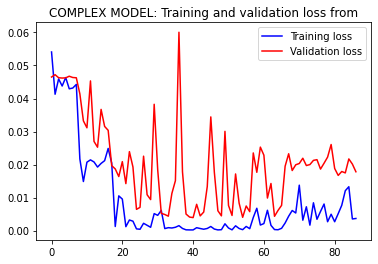

In [ ]:
plot_train_history(modelo_c_history, 'COMPLEX MODEL: Training and validation loss from')

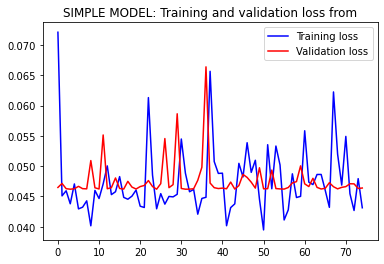

In [ ]:
plot_train_history(modelo_s_history, 'SIMPLE MODEL: Training and validation loss from')

**2-Realizamos predicciones con todos los modelos previamente cargados**

In [ ]:
predicciones = []
nombre_modelos = ['Complejo', 'Simple']

predicciones_c = modelo_c.predict(x_test, verbose = 1)
predicciones_s = modelo_s.predict(x_test, verbose = 1)

predicciones.append(predicciones_s)
predicciones.append(predicciones_c)

1703/1703 [==============================] - 40s 23ms/step


**3.1-Comparamos métricas generales**

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
def obtener_metricas(y_val, y_preds, nombre_modelos):
    #Aplanamos los datos para que se puedan calcular las metricas
    y_val = np.squeeze(y_val)
    y_val = y_val.ravel()
    datos_mse  = []
    datos_r2   = []
    datos_rmse = []
    datos_mae  = []
    columnas   = []
    for modelo in range(len(nombre_modelos)):
        y_pred = np.squeeze(y_preds[modelo])
        y_pred = y_pred.ravel()
        #Calculamos las metricas
        r2   = r2_score(y_val, y_pred)
        mse  = mean_squared_error(y_val, y_pred)
        mae  = mean_absolute_error(y_val, y_pred)
        rmse = mse**0.5
        #Los anadimos a las listas correspondientes
        datos_mse.append(mse)
        datos_r2.append(r2)
        datos_rmse.append(rmse)
        datos_mae.append(mae)
        #Creamos una columna por modelo
        columnas.append('Valor_'+nombre_modelos[modelo])

    #Mostramos los resultados en forma de df
    nombres_metricas = ['R2', 'RMSE', 'MSE', 'MAE']
    valores = [datos_r2, datos_rmse, datos_mse, datos_mae]

    metricas = pd.DataFrame(valores, columns = columnas, index = nombres_metricas)
    return metricas

obtener_metricas(y_test, predicciones)

,Metrica,Valor
0,R2,0.740452
1,RMSE,0.110623
2,MSE,0.012237
3,MAE,0.071096


**3.2-Comparamos métricas para cada timestep**

In [ ]:
#Devuelve una lista por cada timestep, primera lista = conjunto de primeras predicciones, segunda lista = ... de segundas pred..
def desglose_por_timestep(y_val, predicciones):
    #predicciones.shape[0] = numero de predicciones
    #predicciones.shape[1] = numero de timesteps por prediccion
    #predicciones.shape[2] = numero de variables por timestep
    num_predicciones = predicciones.shape[0]
    num_timesteps   = predicciones.shape[1]
    #num_variables   = predicciones.shape[2]
    #DOS BUCLES, UNO POR LISTA
    timesteps_y_val  = []
    timesteps_y_pred = []
    
    #Creamos 4 listas, una para cada timestep
    for lista_timestep in range(num_timesteps):
        timestep_valN = []
        timesteps_y_val.append(timestep_valN)
        timestep_predN = []
        timesteps_y_pred.append(timestep_predN)
    #Metemos en cada una de los 4 listas, el correspondiente timestep de cada prediccion
    for prediccion in range(num_predicciones):
        for timestep in range(num_timesteps):
            timesteps_y_pred[timestep].append(predicciones[prediccion][timestep])
            timesteps_y_val[timestep].append(y_val[prediccion][timestep])
    
    return timesteps_y_val, timesteps_y_pred

def comparacion_modelos_timestep(y_val, predicciones, nombre_modelos):
    timesteps_y_preds = []
    for modelo in range(len(nombre_modelos)):
        timesteps_y_val, timesteps_y_pred_modelo = desglose_por_timestep(y_val, predicciones[modelo])
        timesteps_y_preds.append(timesteps_y_pred_modelo)
    for timestep in range(4):
        timesteps_modelos = []
        for modelo in range(len(nombre_modelos)):
            timesteps_modelos.append(timesteps_y_preds[modelo][timestep])
        print("=========TIMESTEP: ",timestep,"=========\n",obtener_metricas(timesteps_y_val[timestep], timesteps_modelos, nombre_modelos))


pd.set_option("display.max_rows", None, "display.max_columns", None)
comparacion_modelos_timestep(y_test, predicciones, nombre_modelos)


=========TIMESTEP:  0 =========
   Metrica     Valor
0      R2  0.741660
1    RMSE  0.110364
2     MSE  0.012180
3     MAE  0.070820
=========TIMESTEP:  1 =========
   Metrica     Valor
0      R2  0.739653
1    RMSE  0.110793
2     MSE  0.012275
3     MAE  0.071294
=========TIMESTEP:  2 =========
   Metrica     Valor
0      R2  0.739833
1    RMSE  0.110755
2     MSE  0.012267
3     MAE  0.071212
=========TIMESTEP:  3 =========
   Metrica     Valor
0      R2  0.740511
1    RMSE  0.110611
2     MSE  0.012235
3     MAE  0.071085


**3.3-Comparamos métricas para cada timestep y variable**

In [ ]:
def comparacion_modelos_timestep_variables(y_val, predicciones, nombre_modelos):
  nombre_var = df_target.columns
  desglose_preds = []
  for modelo in range(len(nombre_modelos)):
      desglose_val, desglose_pred = agrupar_variables_timestep(y_val, predicciones[modelo])
      desglose_preds.append(desglose_pred)
  
  for paso in range(4):
    print("===================TIMESTEP ", paso,"===================")
    for variable in range(2):
        variableN_modelos = []
        for modelo in range(len(nombre_modelos)):
          variableN_modelos.append(desglose_preds[modelo][paso][variable])
        print("=====VARIABLE", nombre_var[variable],"====")
        print(obtener_metricas(desglose_val[paso][variable], variableN_modelos, nombre_modelos))

comparacion_modelos_timestep_variables(y_test, predicciones, nombre_modelos)